#### Importación de Librerías, definición del dataset y limpieza

Se resumen las tareas correspondientes para avanzar directamente a la resolución de la consigna del desafío.



In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
pd.options.display.max_columns = 100
pd.options.display.float_format = '{:.2f}'.format

#Cargo el Dataset
df = pd.read_csv("https://github.com/JuanPabloVeliz/Coder-DS/blob/main/Dataset/train.csv?raw=true")
print("Dataset cargado.")

#Elimino columnas innecesarias
df.drop(["ID", "Payment Plan", "Accounts Delinquent"], inplace=True, axis=1)
print("Se eliminaron las columnas ID, Payment Plan, y Accounts Delinquent")

#Renombro columnas equivocadas
df.rename(columns={"Home Ownership": "Unknown Value", "Employment Duration": "Home Ownership"}, inplace=True)

#Reduzco la cardinalidad de Loan Title
loan_titles = ["Consolidation", "Refinancing"]
df.loc[df["Loan Title"].str.contains(loan_titles[0], case=False), "Loan Title"] = loan_titles[0]
df.loc[df["Loan Title"].str.contains(loan_titles[1], case=False), "Loan Title"] = loan_titles[1]
df.loc[~df["Loan Title"].str.contains('|'.join(loan_titles), case=False), "Loan Title"] = "Other"


#Transformo las variables categóricas en numéricas
from sklearn.preprocessing import LabelEncoder

home_ownerships = LabelEncoder().fit(df["Home Ownership"])
initial_list_status = LabelEncoder().fit(df["Initial List Status"])
application_types = LabelEncoder().fit(df["Application Type"])
loan_titles =LabelEncoder().fit(df["Loan Title"])
batches_enrolled = LabelEncoder().fit(df["Batch Enrolled"].sort_values())
grades = LabelEncoder().fit(df["Grade"].sort_values())
sub_grades = LabelEncoder().fit(df["Sub Grade"].sort_values())

df["Home Ownership"] = home_ownerships.transform(df["Home Ownership"])
df["Initial List Status"] = initial_list_status.transform(df["Initial List Status"])
df["Application Type"] = application_types.transform(df["Application Type"])
df["Loan Title"] = loan_titles.transform(df["Loan Title"])
df["Batch Enrolled"] = batches_enrolled.transform(df["Batch Enrolled"])
df["Grade"] = grades.transform(df["Grade"])
df["Sub Grade"] = sub_grades.transform(df["Sub Grade"])

df["Verification Status"].replace({"Not Verified": 0, "Source Verified": 1, "Verified": 2}, inplace=True)


#Rebalanceo el dataset 
from sklearn.utils import resample

status_0 = df[df["Loan Status"]==0]
status_1 = df[df["Loan Status"]==1]

status_1_resampled = resample(status_1, n_samples=len(status_0), random_state=50)

resampled_df = pd.concat([status_1_resampled, status_0])

print("Cantidad de muestras luego del rebalanceo:")
print(resampled_df["Loan Status"].value_counts())


#Detecto y remuevo ouliers
from sklearn.ensemble import IsolationForest

clf = IsolationForest(random_state=0)
clf.fit(df)
isolated = clf.predict(resampled_df)
resampled_df["Outlier"] = isolated

clean_df = resampled_df[resampled_df["Outlier"] == 1]
clean_df.drop(columns="Outlier", inplace=True)

print("Resultado de la detección de outliers:")
print(resampled_df["Outlier"].value_counts())

Dataset cargado.
Se eliminaron las columnas ID, Payment Plan, y Accounts Delinquent
Cantidad de muestras luego del rebalanceo:
1    61222
0    61222
Name: Loan Status, dtype: int64
Resultado de la detección de outliers:
 1    110365
-1     12079
Name: Outlier, dtype: int64


### Evaluación de modelos de ML
A continuación voy a comparar los resultados de varios algoritmos que normalmente se utilizan en problemas de clasificación como este en el que estoy trabajando con sus parámetros por defecto. Estos son:
* Decision Tree
* SGD
* KNN
* Random Forest


In [19]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, log_loss, confusion_matrix


In [20]:
# Cargar los datos

X = clean_df.drop(["Loan Status"], axis=1)
y = clean_df["Loan Status"]

# Separacion train/test
X_train, X_test, y_train, y_test = train_test_split(X, y)

#Preparación de funciones para evaluación
def cf_matrix(pred, model):
    cf_matrix = confusion_matrix(df["Loan Status"], pred)
    ax = sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues')
    ax.set_title('Matriz de confusion - '+ model)
    ax.set_xlabel('Valores predichos')
    ax.set_ylabel('Valores reales')
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
    return ax

def metrics(pred, model):
    print("Evaluación del modelo - ", model)
    print("Accuracy (tp + tn / Total): ","{:.2%}".format(accuracy_score(df["Loan Status"], pred)), " Etiquetados correctamente")
    print("Precision Score (tp / (tp + fp)): ","{:.2%}".format(precision_score(df["Loan Status"], pred, average="binary")), " Predicciones positivas acertadas")
    print("Recall Score (tp / (tp + fn)): ","{:.2%}".format(recall_score(df["Loan Status"], pred, average="binary")), " Casos positivos detectados")
    print("F1-Score (2 * (precision * recall ) / (precision + recall)): ","{:.2%}".format(f1_score(df["Loan Status"], pred, average="binary")), " Media armónica entre Precision y Recall")

Instancio cada uno de los clasificadores y realizo las predicciones.

In [21]:
# Decision Tree
#Paso 1 :Instanciar
model = DecisionTreeClassifier(random_state=0, class_weight="balanced")
#Paso 2 : Fit con la información
model.fit(X_train, y_train)
#Paso 3 : Predicción
dt_pred = model.predict(df.drop(["Loan Status"], axis=1))


In [22]:
# SGD Classifier
#Paso 1: Instanciar el objeto
model = SGDClassifier(n_jobs=-1) 
#Paso 2: Ajustar el modelo
model.fit(X_train, y_train) 
#Paso 3: Predicción del modelo
sgd_pred = model.predict(df.drop(["Loan Status"], axis=1))

In [23]:
# K-Neighbors
#Paso 1: Instanciar el objeto
model = KNeighborsClassifier(n_jobs=-1) 
#Paso 2: Ajustar el modelo
model.fit(X_train, y_train) 
#Paso 3: Predicción del modelo
knn_pred = model.predict(df.drop(["Loan Status"], axis=1))

In [24]:
# Random Forest
#Paso 1: Instanciar el objeto
model = RandomForestClassifier(n_jobs=-1) 
#Paso 2: Ajustar el modelo
model.fit(X_train, y_train) 
#Paso 3: Predicción del modelo
rdf_pred = model.predict(df.drop(["Loan Status"], axis=1))

Ploteo las matrices de confusión a modo de compración:

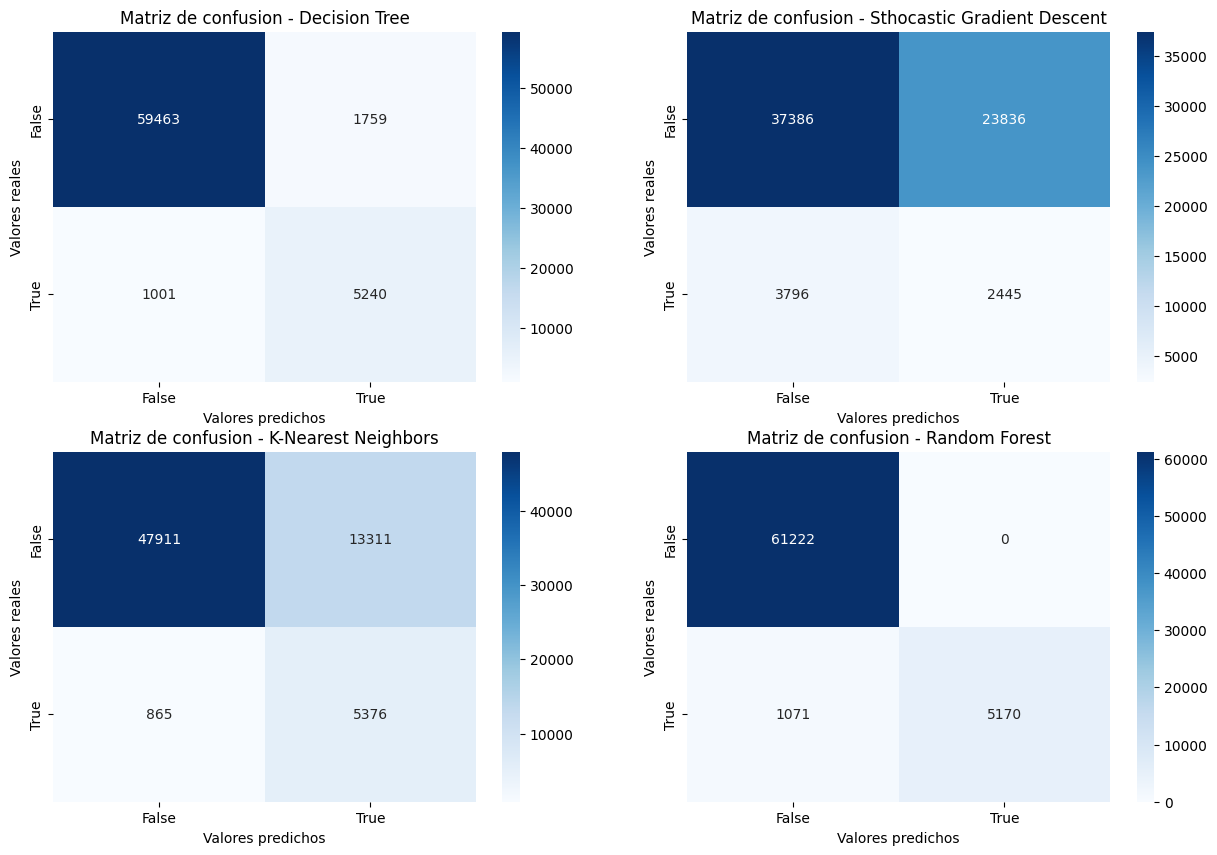

In [25]:
models = ({"Decision Tree":dt_pred, "Sthocastic Gradient Descent":sgd_pred,"K-Nearest Neighbors":knn_pred, "Random Forest":rdf_pred})

fig, axs = plt.subplots(2,2, figsize=(15,10))

i=0
for title, model in models.items():
    plt.subplot(2,2,i+1)
    cf_matrix(model, title)
    i +=1

En las matrices se ve que el Decision Tree parece ser el más confiable en esta instancia de pruebas iniciales aunque aún lejos de tener una buena performance.

In [26]:
metricas = pd.DataFrame(({'metricas':['Accuracy', 'Precision', 'Recall', 'F1-Score']}))

for model, pred in models.items():
    metricas[model] = [accuracy_score(df["Loan Status"], pred),
                        precision_score(df["Loan Status"], pred),
                        recall_score(df["Loan Status"], pred), 
                        f1_score(df["Loan Status"], pred)]

metricas

,metricas,Decision Tree,Sthocastic Gradient Descent,K-Nearest Neighbors,Random Forest
0,Accuracy,0.96,0.59,0.79,0.98
1,Precision,0.75,0.09,0.29,1.00
2,Recall,0.84,0.39,0.86,0.83
3,F1-Score,0.79,0.15,0.43,0.91


#### Conclusión
La comparación numérica de las métricas confirma la percepción obtenida al mirar las matrices de confusión. 

De los modelos probados, el SGD y el KNN son los de peor desempeño, mientras que el Desicion Tree y el Random Forest se comportan de forma satisfactoria y bastante similar.

Si bien las métricas del Random Forest son más altas, podríamos estar frente a un caso de overfitting. Además el Recall del Decision Tree es mayor y, tal como se comentó anteriormente, esta medida es la más relevante para el contexto del negocio.

La conclusión final es que el Decision Tree es el algoritmo más aconsejable para seguir trabajando.